In [354]:
import numpy as np
import nltk
from nltk.corpus import brown
import math
from sklearn import metrics
nltk.download("brown")
nltk.download("universal_tagset")
nltk.download("punkt")

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [355]:
import re
def preprocess_word(word):
  word = word.lower()
  word = re.sub("n't","",word)
  word = re.sub("[0-9]+","1",word)
  return word
preprocess = np.vectorize(preprocess_word)

In [356]:
class POS_tagger:
  def __init__(self, train_sentences):
    self.words = None
    self.lexical_probability = None

    self.sentences = train_sentences
    self.inference = None

    self.tagset = None
    self.tagset_len = 0
    
    self.vocab = None
    self.word_to_id = None  # dictionary (word : id)
    self.vocab_len = 0

    self.smoothing = None   # vectorised function (numpy) for smoothing
  
  def initialise(self):
    self.words = []
    for sentence in self.sentences:
      for tupl in sentence:
        self.words.append(tupl)

    self.words = np.array(self.words)
    self.words[:,0] = preprocess(self.words[:,0])

    self.tagset = np.unique(self.words[:,1])
    
    self.vocab, word_count = np.unique(self.words[:,0], return_counts = True)
    self.vocab = self.vocab[word_count > 1]

    self.word_to_id = dict(zip(self.vocab, np.arange(self.vocab.size)))
    self.word_to_id["UNK"] = self.vocab.size

    self.vocab_len = len(self.word_to_id)
    self.tagset_len = len(self.tagset)

    def smooth(word):
      if word not in self.word_to_id:
        return "UNK"
      else:
        return word
    self.smoothing = np.vectorize(smooth)

    self.words[:,0] = self.smoothing(self.words[:,0])

    self.lexical_probability = np.zeros((self.tagset_len, self.vocab_len))
    self.inference = np.zeros((self.tagset_len+2, self.tagset_len+2))

  def train(self):
    self.initialise()

    for tag_index in range(self.tagset_len):
      tag = self.tagset[tag_index]
      tokens, count = np.unique(self.words[np.where(self.words[:,1] == tag), 0], return_counts = True)
      # token_indices = np.searchsorted(vocab, tokens)
      token_indices = [self.word_to_id[token] for token in tokens]
      self.lexical_probability[tag_index][token_indices] = count

    self.lexical_probability = self.lexical_probability / self.lexical_probability.sum(1).reshape(self.lexical_probability.shape[0],1)

    for sentence in self.sentences:
      prev_tag = None
      for (word,tag) in sentence:
        if prev_tag == None:
          from_tag = 0
          to_tag =  np.searchsorted(self.tagset,tag) + 1
        elif word in [".","?"]:
          from_tag = np.searchsorted(self.tagset,prev_tag) + 1
          to_tag = self.tagset_len + 1
        else:
          from_tag = np.searchsorted(self.tagset,prev_tag) + 1
          to_tag =  np.searchsorted(self.tagset,tag) + 1
        self.inference[from_tag][to_tag] += 1
        prev_tag = tag
    self.inference[-1,0] = 1
    self.inference = self.inference / self.inference.sum(1).reshape(self.inference.shape[0],1)

  def tag(self,sentence):
    sentence = np.array(sentence, dtype="object")
    sentence = self.smoothing(preprocess(sentence))

    ends_properly = True
    if sentence[-1] not in [".","?","!"]:
      sentence = np.append(sentence, ".")
      ends_properly = False
    
    prob = np.zeros((self.tagset_len,1))
    tags_chain = np.full((self.tagset_len, len(sentence) - 1), -1)
    last_word_tag = None
    
    for i in range(len(sentence)):
      if i == 0:
        prob = self.inference[0][1:-1]
        tags_chain[:,i] = -1
        continue
      
      word = sentence[i-1]
      lp = self.lexical_probability[:, self.word_to_id[word]]
      # if(np.max(prob)<0.0000001):   # to prevent probabilities underflowing to zero
      #   prob=prob/np.max(prob)
      prob = prob*lp

      if i == len(sentence) - 1:
        prob = prob*self.inference[1:-1,-1]
        last_word_tag = np.argmax(prob)
        break
      else:
        p_inf = prob.reshape((self.tagset_len,1))*self.inference[1:-1, 1:-1]
        indices = np.argmax(p_inf, axis = 0)
        prob = p_inf[indices,np.arange(self.tagset_len)]
        tags_chain[:,i] = indices

    tagged_sentence = np.array([[word,""] for word in sentence], dtype="object")
    iter = len(sentence) - 1
    while iter >=0 :
      if iter == len(sentence) - 1:
        tag_index = 0
      else:
        tag_index = last_word_tag
        last_word_tag = tags_chain[last_word_tag, iter]

      tagged_sentence[iter][1] = self.tagset[tag_index]
      
      iter -= 1
    
    if not ends_properly: # remove the full stop we appended
      tagged_sentence = tagged_sentence[:-1]
    
    return tagged_sentence  

In [357]:
frac = 0.8
all_sentences = np.array(brown.tagged_sents(tagset="universal"), dtype="object")
n_total = len(all_sentences)
n_train = math.floor(n_total*frac)

indices = np.arange(n_total)
np.random.shuffle(indices)

train_sents = all_sentences[ indices[ : n_train] ]
val_sents = all_sentences[ indices[n_train : ] ]

In [358]:
myTagger = POS_tagger(train_sents)

In [359]:
myTagger.train()

In [360]:
np.set_printoptions(linewidth=200)

In [361]:
def tag(sentence):  # sentence as a string
  sentence = nltk.tokenize.word_tokenize(sentence)
  tags = myTagger.tag(sentence)[:,1]
  return list(zip(sentence, tags))

tag("Margav is the founder of markov models")

[('Margav', 'NOUN'),
 ('is', 'VERB'),
 ('the', 'DET'),
 ('founder', 'NOUN'),
 ('of', 'ADP'),
 ('markov', 'ADJ'),
 ('models', 'NOUN')]

In [362]:
pred = []
true = []
for sentence in val_sents:
  sentence = np.array(sentence)
  true = true + list(sentence[:,1])
  if len(sentence) == 1:
    pred = pred + ["."]
  else:
    pred = pred + list(myTagger.tag(sentence[:,0])[:,1])

In [363]:
print(metrics.classification_report(true, pred, digits=4))

              precision    recall  f1-score   support

           .     0.9975    0.9998    0.9987     29559
         ADJ     0.8766    0.9244    0.8999     16543
         ADP     0.9630    0.9656    0.9643     28753
         ADV     0.9125    0.8885    0.9003     11296
        CONJ     0.9926    0.9947    0.9937      7573
         DET     0.9925    0.9867    0.9896     27187
        NOUN     0.9519    0.9572    0.9545     55002
         NUM     0.9688    0.9746    0.9717      2958
        PRON     0.9718    0.9827    0.9772      9941
         PRT     0.9076    0.8997    0.9036      5952
        VERB     0.9745    0.9453    0.9597     36806
           X     0.3529    0.5286    0.4233       227

    accuracy                         0.9602    231797
   macro avg     0.9052    0.9207    0.9114    231797
weighted avg     0.9608    0.9602    0.9604    231797



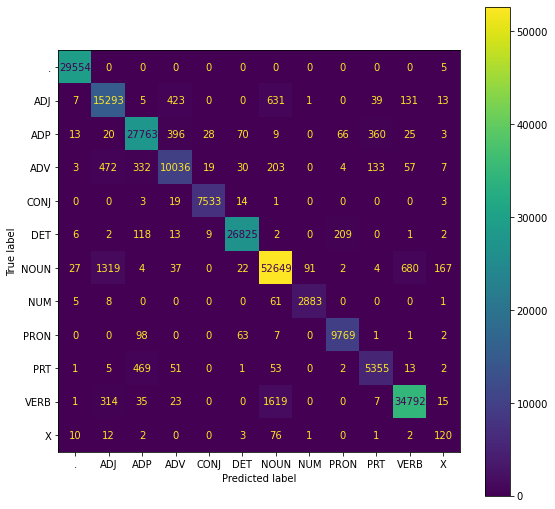

In [364]:
# cm = metrics.confusion_matrix(true,pred)
# print(cm)
# metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = preprocess(myTagger.tagset)).plot(include_values = False)
disp = metrics.ConfusionMatrixDisplay.from_predictions( true, pred, labels=myTagger.tagset, display_labels=myTagger.tagset, values_format='') 
fig = disp.ax_.get_figure() 
fig.set_figwidth(9)
fig.set_figheight(9)  

Following code does the same thing as before but for different training and validation sets in order to calculate 5-fold cross-validation accuracy

In [ ]:
frac = 0.2
all_sentences = np.array(brown.tagged_sents(tagset="universal"), dtype="object")
n_total = len(all_sentences)
n_val = math.floor(n_total*frac)

indices = np.arange(n_total)
np.random.shuffle(indices)

cross_valdation_accuracies = np.zeros(5)

for k in range(5):
  tmp = np.floor(np.arange(n_total)/n_val)
  train_ids = indices[ tmp != k ]
  val_ids = indices[ tmp == k ]
  
  train_sents = all_sentences[ train_ids ]
  val_sents = all_sentences[ val_ids ]

  myTagger = POS_tagger(train_sents)
  myTagger.train()

  pred = []
  true = []
  for sentence in val_sents:
    sentence = np.array(sentence)
    true = true + list(sentence[:,1])
    if len(sentence) == 1:
      pred = pred + ["."]
    else:
      pred = pred + list(myTagger.tag(sentence[:,0])[:,1])

  from sklearn import metrics
  cm = metrics.confusion_matrix(true,pred)

  cross_valdation_accuracies[k] = np.trace(cm)/np.sum(cm)

In [ ]:
print(cross_valdation_accuracies)
print(cross_valdation_accuracies.mean())

[0.95991224 0.95834231 0.95916113 0.96062028 0.95981803]
0.9595707995084093
